In [2]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.3 MB 11.2 MB/s eta 0:00:02
   ---------------- ----------------------- 5.5/13.3 MB 15.3 MB/s eta 0:00:01
   --------------------------- ------------ 9.2/13.3 MB 16.3 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 17.5 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 14.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --------------------------------- ------ 1.0/1.3 MB 49.2 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.3 MB/s eta 0:00:00


In [24]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurações
plt.rcParams["figure.figsize"] = (12, 6)

In [25]:
#Carregamento do dataset 
df = pd.read_csv("data/processed/dataset_clean.csv")

# Agrupa por semana (média dos municípios)
df_grouped = df.groupby(["year", "week"], as_index=False)["casos"].mean()

# Cria coluna de data a partir de ano e semana
from datetime import datetime
df_grouped["ds"] = df_grouped.apply(
    lambda row: datetime.fromisocalendar(int(row["year"]), int(row["week"]), 1),
    axis=1
)

# Renomeia coluna alvo para Prophet
df_grouped.rename(columns={"casos": "y"}, inplace=True)

# Ordena e filtra
df_prophet = df_grouped[["ds", "y"]].sort_values("ds").dropna()

In [26]:
#Divide em treino e teste
split = int(0.8 * len(df_prophet))
df_train = df_prophet[:split]
df_test = df_prophet[split:]

In [27]:
#Define e treina modelo Prophet
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(df_train)

10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
#Previsões
future = model.make_future_dataframe(periods=len(df_test), freq="W-MON")
forecast = model.predict(future)

# Junta previsões com dados reais
df_forecast = forecast[["ds", "yhat"]].set_index("ds")
df_test = df_test.set_index("ds")
df_eval = df_test.join(df_forecast, how="left")

In [29]:
#Avaliação
# Junta e remove NaNs
df_clean = df_eval.dropna()

mae = mean_absolute_error(df_clean["y"], df_clean["yhat"])
rmse = np.sqrt(mean_squared_error(df_clean["y"], df_clean["yhat"]))
r2 = r2_score(df_clean["y"], df_clean["yhat"])

print(f"Prophet → MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

Prophet → MAE: 0.0145 | RMSE: 0.0202 | R²: 0.5261


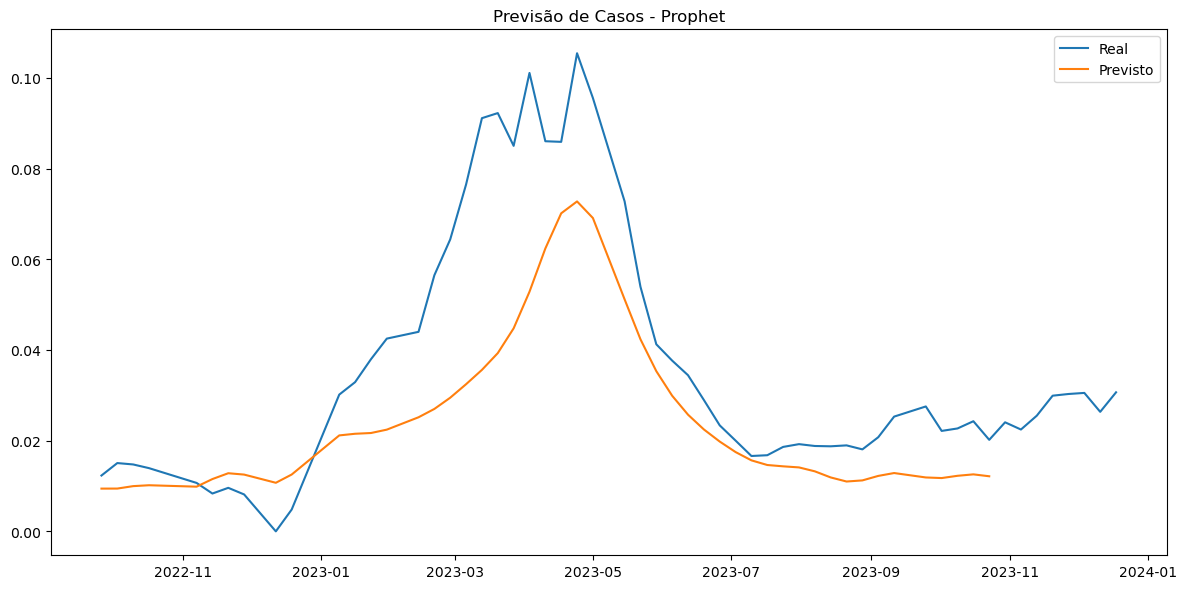

In [30]:
#Visualização
plt.plot(df_eval["y"], label="Real")
plt.plot(df_eval["yhat"], label="Previsto")
plt.title("Previsão de Casos - Prophet")
plt.legend()
plt.tight_layout()
plt.show()

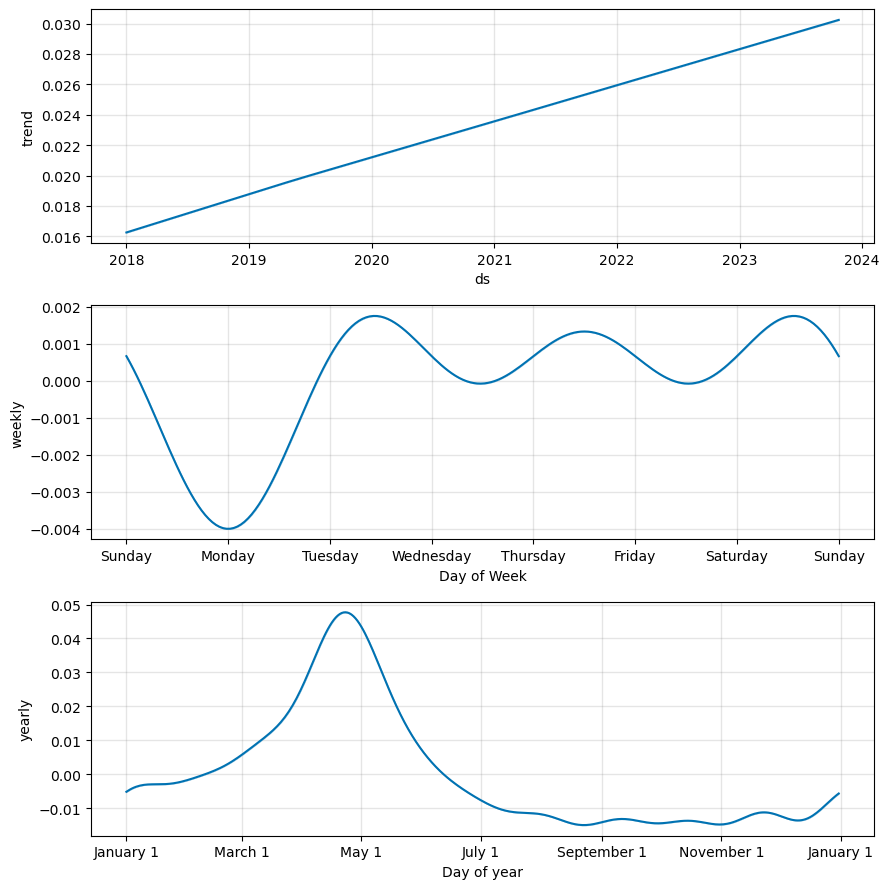

In [31]:
#Componentes da previsão
model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [32]:
#Métricas geradas
#MAE: erro absoluto médio
#RMSE: raiz do erro quadrático médio
#R²: coeficiente de determinação

#Saídas
#Gráfico de previsão real vs. previsto
#Componentes da previsão (tendência, sazonalidade)
#Avaliação quantitativa do modelo Prophet